In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import dolfinx as dfx

import h5py

from dolfinx.fem.petsc import NonlinearProblem

%matplotlib widget
from matplotlib import pyplot as plt
# plt.style.use('fivethirtyeight')

from mpi4py import MPI

import numpy as np

from pathlib import Path

import ufl

from pyMoBiMP.cahn_hilliard_utils import (
    cahn_hilliard_form,
    charge_discharge_stop, 
    AnalyzeOCP,
    y_of_c,
    c_of_y,
    populate_initial_data)

from pyMoBiMP.fenicsx_utils import (evaluation_points_and_cells,
                           get_mesh_spacing,
                           time_stepping,
                           NewtonSolver,
                           FileOutput,
                           Fenicx1DOutput)

from pyMoBiMP.gmsh_utils import dfx_spherical_mesh

from pyMoBiMP.plotting_utils import (
    add_arrow, 
    plot_charging_cycle, 
    plot_time_sequence,
    PyvistaAnimation,
    animate_time_series)

comm_world = MPI.COMM_WORLD

In [ ]:
# Discretization
# --------------

# Set up the mesh
n_elem = 128

mesh = dfx.mesh.create_unit_interval(comm_world, n_elem)

dx_cell = get_mesh_spacing(mesh)

print(f"Cell spacing: h = {dx_cell}")

# For later plotting use
x = np.linspace(0, 1, 101)
points_on_proc, cells = evaluation_points_and_cells(mesh, x)

# Initial timestep size
dt = dfx.fem.Constant(mesh, dx_cell * 0.01)

In [ ]:
elem1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)

elem_c = elem1
elem_mu = elem1

num_particles = 2

multi_particle_element = ufl.MixedElement(
    [[elem_c, ] * num_particles,
        [elem_mu, ] * num_particles]
    )

V = dfx.fem.FunctionSpace(mesh, multi_particle_element)

In [ ]:
# The mixed-element functions
u = dfx.fem.Function(V)
u0 = dfx.fem.Function(V)

In [ ]:
# Compute the chemical potential df/dc
a = 6. / 4
b = 0.2
cc = 5

# a = 5. # 6. / 4
# b = 0. # 0.2
# cc = 0 # 5

free_energy = lambda u, log, sin: u * log(u) + (1-u) * log(1-u) + a * u * (1 - u) + b * sin(cc * np.pi * u)

fig, ax = plt.subplots()

eps = 1e-3

c_plot = np.linspace(eps, 1-eps, 200)

ax.plot(c_plot, free_energy(c_plot, np.log, np.sin))

ax.set_xlabel(r"$c$")
ax.set_ylabel(r"$F(c)$")

plt.show()

In [ ]:
# Experimental setup
# ------------------

# charging current
I_charge = dfx.fem.Constant(mesh, 1e-1)

T_final = 2. / I_charge.value  # ending time

def experiment(t, u, I_charge, **kwargs):

    return charge_discharge_stop(t, u, I_charge, c_of_y = c_of_y, **kwargs)

event_params = dict(I_charge=I_charge, stop_on_full=False, stop_at_empty=False, cycling=False, logging=True)

In [ ]:
# The variational form
# --------------------

form_weights = None
M = lambda c: c * (1 - c)
theta = 1.
lam = 0.1
grad_c_bc = lambda c: 0.

alpha = 10.

h = ufl.Circumradius(mesh)

params = dict(I_charge=I_charge, grad_c_bc=lambda c: 0.1 * I_charge)

y, mu = ufl.split(u)
y0, mu0 = ufl.split(u0)

y1, y2 = ufl.split(y)
y1, y2 = ufl.variable(y1), ufl.variable(y2)

y01, y02 = ufl.split(y0)

c1, c2 = c_of_y(y1), c_of_y(y2)
c1, c2 = ufl.variable(c1), ufl.variable(c2)

dcdy1, dcdy2 = ufl.diff(c1, y1), ufl.diff(c2, y2)

v_c, v_mu = ufl.TestFunctions(V)

v_c1, v_c2 = ufl.split(v_c)
v_mu1, v_mu2 = ufl.split(v_mu)

mu1, mu2 = ufl.split(mu)
mu01, mu02 = ufl.split(mu0)

f_e1, f_e2 = free_energy(c1, ufl.ln, ufl.sin), free_energy(c2, ufl.ln, ufl.sin)

mu_chem1, mu_chem2 = ufl.diff(f_e1, c1), ufl.diff(f_e2, c2)

mu_theta1, mu_theta2 = theta * mu1 + (theta - 1.0) * mu01, theta * mu2 + (theta - 1.0) * mu02

r = ufl.SpatialCoordinate(mesh)

# adaptation of the volume element due to geometry
if form_weights is not None:
    s_V = form_weights["volume"]
    s_A = form_weights["surface"]
else:
    s_V = 4 * np.pi * r**2
    s_A = 2 * np.pi * r**2

    dx = ufl.dx  # The volume element
    ds = ufl.ds  # The surface element

dx = ufl.dx  # The volume element
ds = ufl.ds  # The surface element

flux1, flux2 = M(c1) * ufl.grad(mu_theta1), M(c2) * ufl.grad(mu_theta2)

n = n_1 = n_2 = ufl.FacetNormal(mesh)

I_charge1 = I_charge - M(c2) * ufl.dot(n_2, ufl.grad(mu2))
I_charge2 = I_charge - M(c1) * ufl.dot(n_1, ufl.grad(mu1))

F11 = s_V * dcdy1 * (y1 - y01) * v_c1 * dx
F11 += s_V * ufl.dot(flux1, ufl.grad(v_c1)) * dt * dx
F11 -= I_charge1 * s_A * v_c1 * dt * ds

F21 = s_V * mu1 * v_mu1 * dx
F21 -= s_V * mu_chem1 * v_mu1 * dx
F21 -= lam * (s_V * ufl.inner(ufl.grad(c1), ufl.grad(v_mu1)) * dx)
F21 +=  grad_c_bc(c1) * (s_A * v_mu1 * ds)

F21 += ufl.dot(ufl.grad(v_mu1), n_1) * (mu1 - mu2) * s_A * ds
F21 -= alpha / h * (mu1 - mu2) * v_mu1 * s_A * ds

F12 = s_V * dcdy1 * (y2 - y02) * v_c2 * dx
F12 += s_V * ufl.dot(flux2, ufl.grad(v_c2)) * dt * dx
F12 -= I_charge2 * s_A * v_c2 * dt * ds

F22 = s_V * mu2 * v_mu2 * dx
F22 -= s_V * mu_chem2 * v_mu2 * dx
F22 -= lam * (s_V * ufl.inner(ufl.grad(c2), ufl.grad(v_mu2)) * dx)
F22 +=  grad_c_bc(c2) * (s_A * v_mu2 * ds)

F22 += ufl.dot(ufl.grad(v_mu2), n_2) * (mu2 - mu1) * s_A * ds
F22 -= alpha / h * (mu2 - mu1) * v_mu2 * s_A * ds

F = F11 + F12 + F21 + F22

In [ ]:
# Initial data
# ------------

u_ini = dfx.fem.Function(V)

# Constant
c_ini_fun = lambda x: eps * np.ones_like(x[0])


# Store concentration-like quantity into state vector
# ---------------------------------------------------

V_c, _ = V.sub(0).collapse()

c_ini = dfx.fem.Function(V_c)

c_ini.sub(0).interpolate(c_ini_fun)
c_ini.sub(1).interpolate(lambda x: 2 * c_ini_fun(x))

y_ini1 = dfx.fem.Expression(y_of_c(c_ini.sub(0)),
                            c_ini.sub(0).function_space.element.interpolation_points())
y_ini2 = dfx.fem.Expression(y_of_c(c_ini.sub(1)),
                            c_ini.sub(1).function_space.element.interpolation_points())

u_ini.sub(0).sub(0).interpolate(y_ini1)
u_ini.sub(0).sub(1).interpolate(y_ini2)

# Store chemical potential into state vector
# ------------------------------------------

c_ini1 = ufl.variable(c_ini.sub(0))
dFdc1 = ufl.diff(free_energy(c_ini1, ufl.ln, ufl.sin), c_ini1)

W = u_ini.sub(1).sub(0).function_space
u_ini.sub(1).sub(0).interpolate(dfx.fem.Expression(dFdc1, W.element.interpolation_points()))

c_ini2 = ufl.variable(c_ini.sub(1))
dFdc2 = ufl.diff(free_energy(c_ini2, ufl.ln, ufl.sin), c_ini2)

W = u_ini.sub(1).sub(1).function_space
u_ini.sub(1).sub(1).interpolate(dfx.fem.Expression(dFdc2, W.element.interpolation_points()))

u_ini.x.scatter_forward()

plt.figure()

plt.plot(x, u_ini.sub(0).sub(0).eval(points_on_proc, cells), label="y1")
plt.plot(x, u_ini.sub(0).sub(1).eval(points_on_proc, cells), label="y2")

plt.plot(x, c_ini.sub(0).eval(points_on_proc, cells), label="c1")
plt.plot(x, c_ini.sub(1).eval(points_on_proc, cells), label="c2")

plt.plot(x, u_ini.sub(1).sub(0).eval(points_on_proc, cells), '-.', label=r"$\mu$1")
plt.plot(x, u_ini.sub(1).sub(1).eval(points_on_proc, cells), '-.', label=r"$\mu$2")

plt.legend()

plt.show()

In [ ]:
problem = NonlinearProblem(F, u)

solver = NewtonSolver(comm_world, problem)

In [ ]:
class Output(Fenicx1DOutput):

    def extract_output(self, u_state, t):

        # TODO: Make sure self.u_state and u_state are consistent.
        V = self.u_state.function_space

        num_comp = V.num_sub_spaces

        output_snapshot = []

        for i_comp in range(V.num_sub_spaces):

            V_sub = V.sub(i_comp)

            for k_comp in range(V_sub.num_sub_spaces):

                values = u_state.sub(i_comp).sub(k_comp).eval(self.x_eval, self.cells)

                output_snapshot.append(values)

        return output_snapshot

In [ ]:
# Set up experiment
# -----------------

u.interpolate(u_ini)

n_out = 501

output_np = Output(u, np.linspace(0, T_final, n_out), x)

results_folder = Path("simulation_output")
results_folder.mkdir(exist_ok=True, parents=True)

filename = results_folder / "CH_4_min_1D.xdmf"
output_xdmf = None # FileOutput(u, np.linspace(0, T_final, n_out), filename)

rt_analysis = AnalyzeOCP(c_of_y=c_of_y, filename=results_folder / "CH_4_min_1D_rt.txt")

In [ ]:
# Run the experiment
# ------------------

time_stepping(
    solver,
    u,
    u0,
    T_final,
    dt,
    dt_max=1e-3,
    dt_min=1e-12,
    tol=1e-8,
    event_handler=lambda *args, **kwargs: False,
    output=output_np,
    runtime_analysis=None,
    **event_params,
)

In [ ]:
x_data, t, u_data = output_np.get_output(return_coords=True, return_time=True)

u_data_1 = np.array(u_data)[:, :2, :, :]
u_data_2 = np.array(u_data)[:, 2:, :, :]

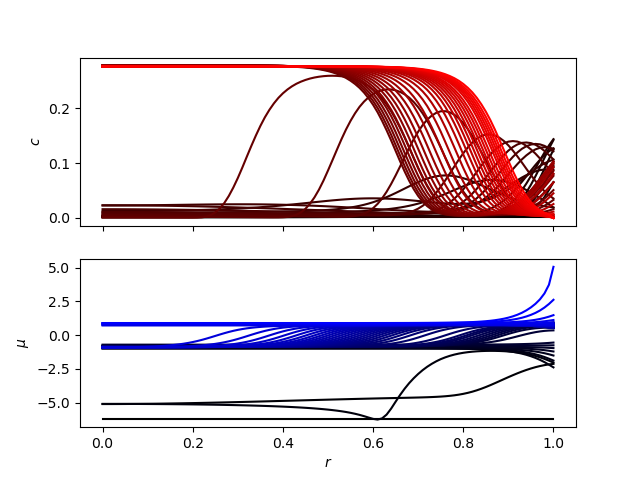

In [45]:
fig, ax = plot_time_sequence((x_data, t, u_data_1), lambda y: np.exp(y) / (1 + np.exp(y)))

plt.show()

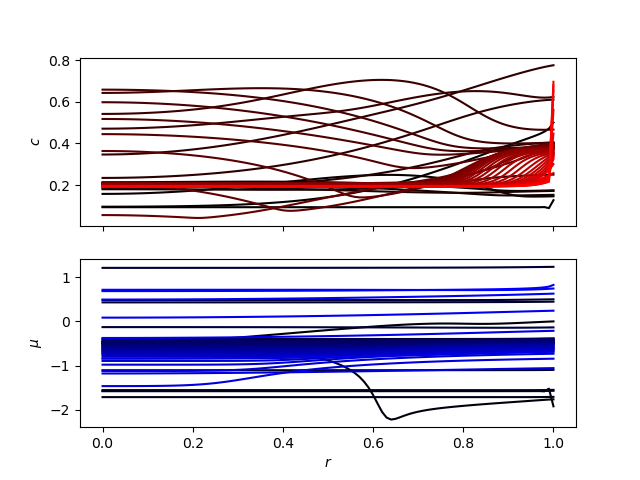

In [46]:
fig, ax = plot_time_sequence((x_data, t, u_data_2), lambda y: np.exp(y) / (1 + np.exp(y)))

plt.show()

In [ ]:
mesh_3d, _, _ = dfx_spherical_mesh(comm_world, resolution=0.1, optimize=False)

In [ ]:
chem_pot = lambda q: np.log(q / (1 - q)) + a * (1 - 2 * q) + b * np.pi * cc * np.cos(np.pi * cc * q)

anim = PyvistaAnimation(
    (x_data, t, u_data),
    rt_data=rt_data,
    mesh_3d=mesh_3d,
    c_of_y=lambda y: np.exp(y) / (1 + np.exp(y)),
    f_of_q=chem_pot,
    res=1.0,
    clim=[0.0, 1.0],
    cmap="fire",
)

widget = anim.get_slider_widget()

In [ ]:
pp_folder = Path("pp_output")
pp_folder.mkdir(exist_ok=True, parents=True)

anim.get_mp4_animation(pp_folder/"CH_4_min.mp4")

In [ ]:
q, f_bar, mu_bc = np.array(rt_analysis.data).T

chart = plot_charging_cycle([(r"$\mu|_{\partial\omega_I}$", q, mu_bc),
                             (rf"$\bar f_A$", q, f_bar)], lambda q: chem_pot(q))